In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


In [2]:
# CHOOSE DATASET

# Binary classification dataset
diabetes = datasets.load_diabetes(as_frame=True)

# Regression dataset
#data = datasets.fetch_openml(name="boston",version=1, as_frame=True) 

X = diabetes.data.values
y = diabetes.target.values

print("Shape:", X.shape)

print(diabetes.data.head(), "\n \n")# first rows of features
print(diabetes.target.head()) # first rows of target


Shape: (442, 10)
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641   
 

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In [5]:
#Number of clusters 
n_clusters = 4
m=1.1

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
centers.shape

(4, 11)

In [7]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Cluster Visualization

In [8]:
'''# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()'''

'# Hard clustering from fuzzy membership\ncluster_labels = np.argmax(u, axis=0)\nprint("Fuzzy partition coefficient (FPC):", fpc)\n\n# Plot first two features with fuzzy membership\nplt.figure(figsize=(8,6))\nfor j in range(n_clusters):\n    plt.scatter(\n        Xexp[cluster_labels == j, 0],             # Feature 1\n        Xexp[cluster_labels == j, 1],             # Feature 2\n        alpha=u[j, :],          # transparency ~ membership\n        label=f\'Cluster {j}\'\n    )\n\nplt.title("Fuzzy C-Means Clustering (with membership degree)")\nplt.xlabel("Feature 1")\nplt.ylabel("Feature 2")\nplt.legend()\nplt.show()'

In [9]:
'''# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()'''

'# Plot first two features with cluster assignments\nplt.figure(figsize=(8,6))\nfor j in range(n_clusters):\n    plt.scatter(\n        Xexp[cluster_labels == j, 0],\n        Xexp[cluster_labels == j, 1],\n        label=f\'Cluster {j}\'\n    )\n\nplt.title("Fuzzy C-Means Clustering (CRISPEN)")\nplt.xlabel("Feature 1")\nplt.ylabel("Feature 2")\nplt.legend()\nplt.show()'

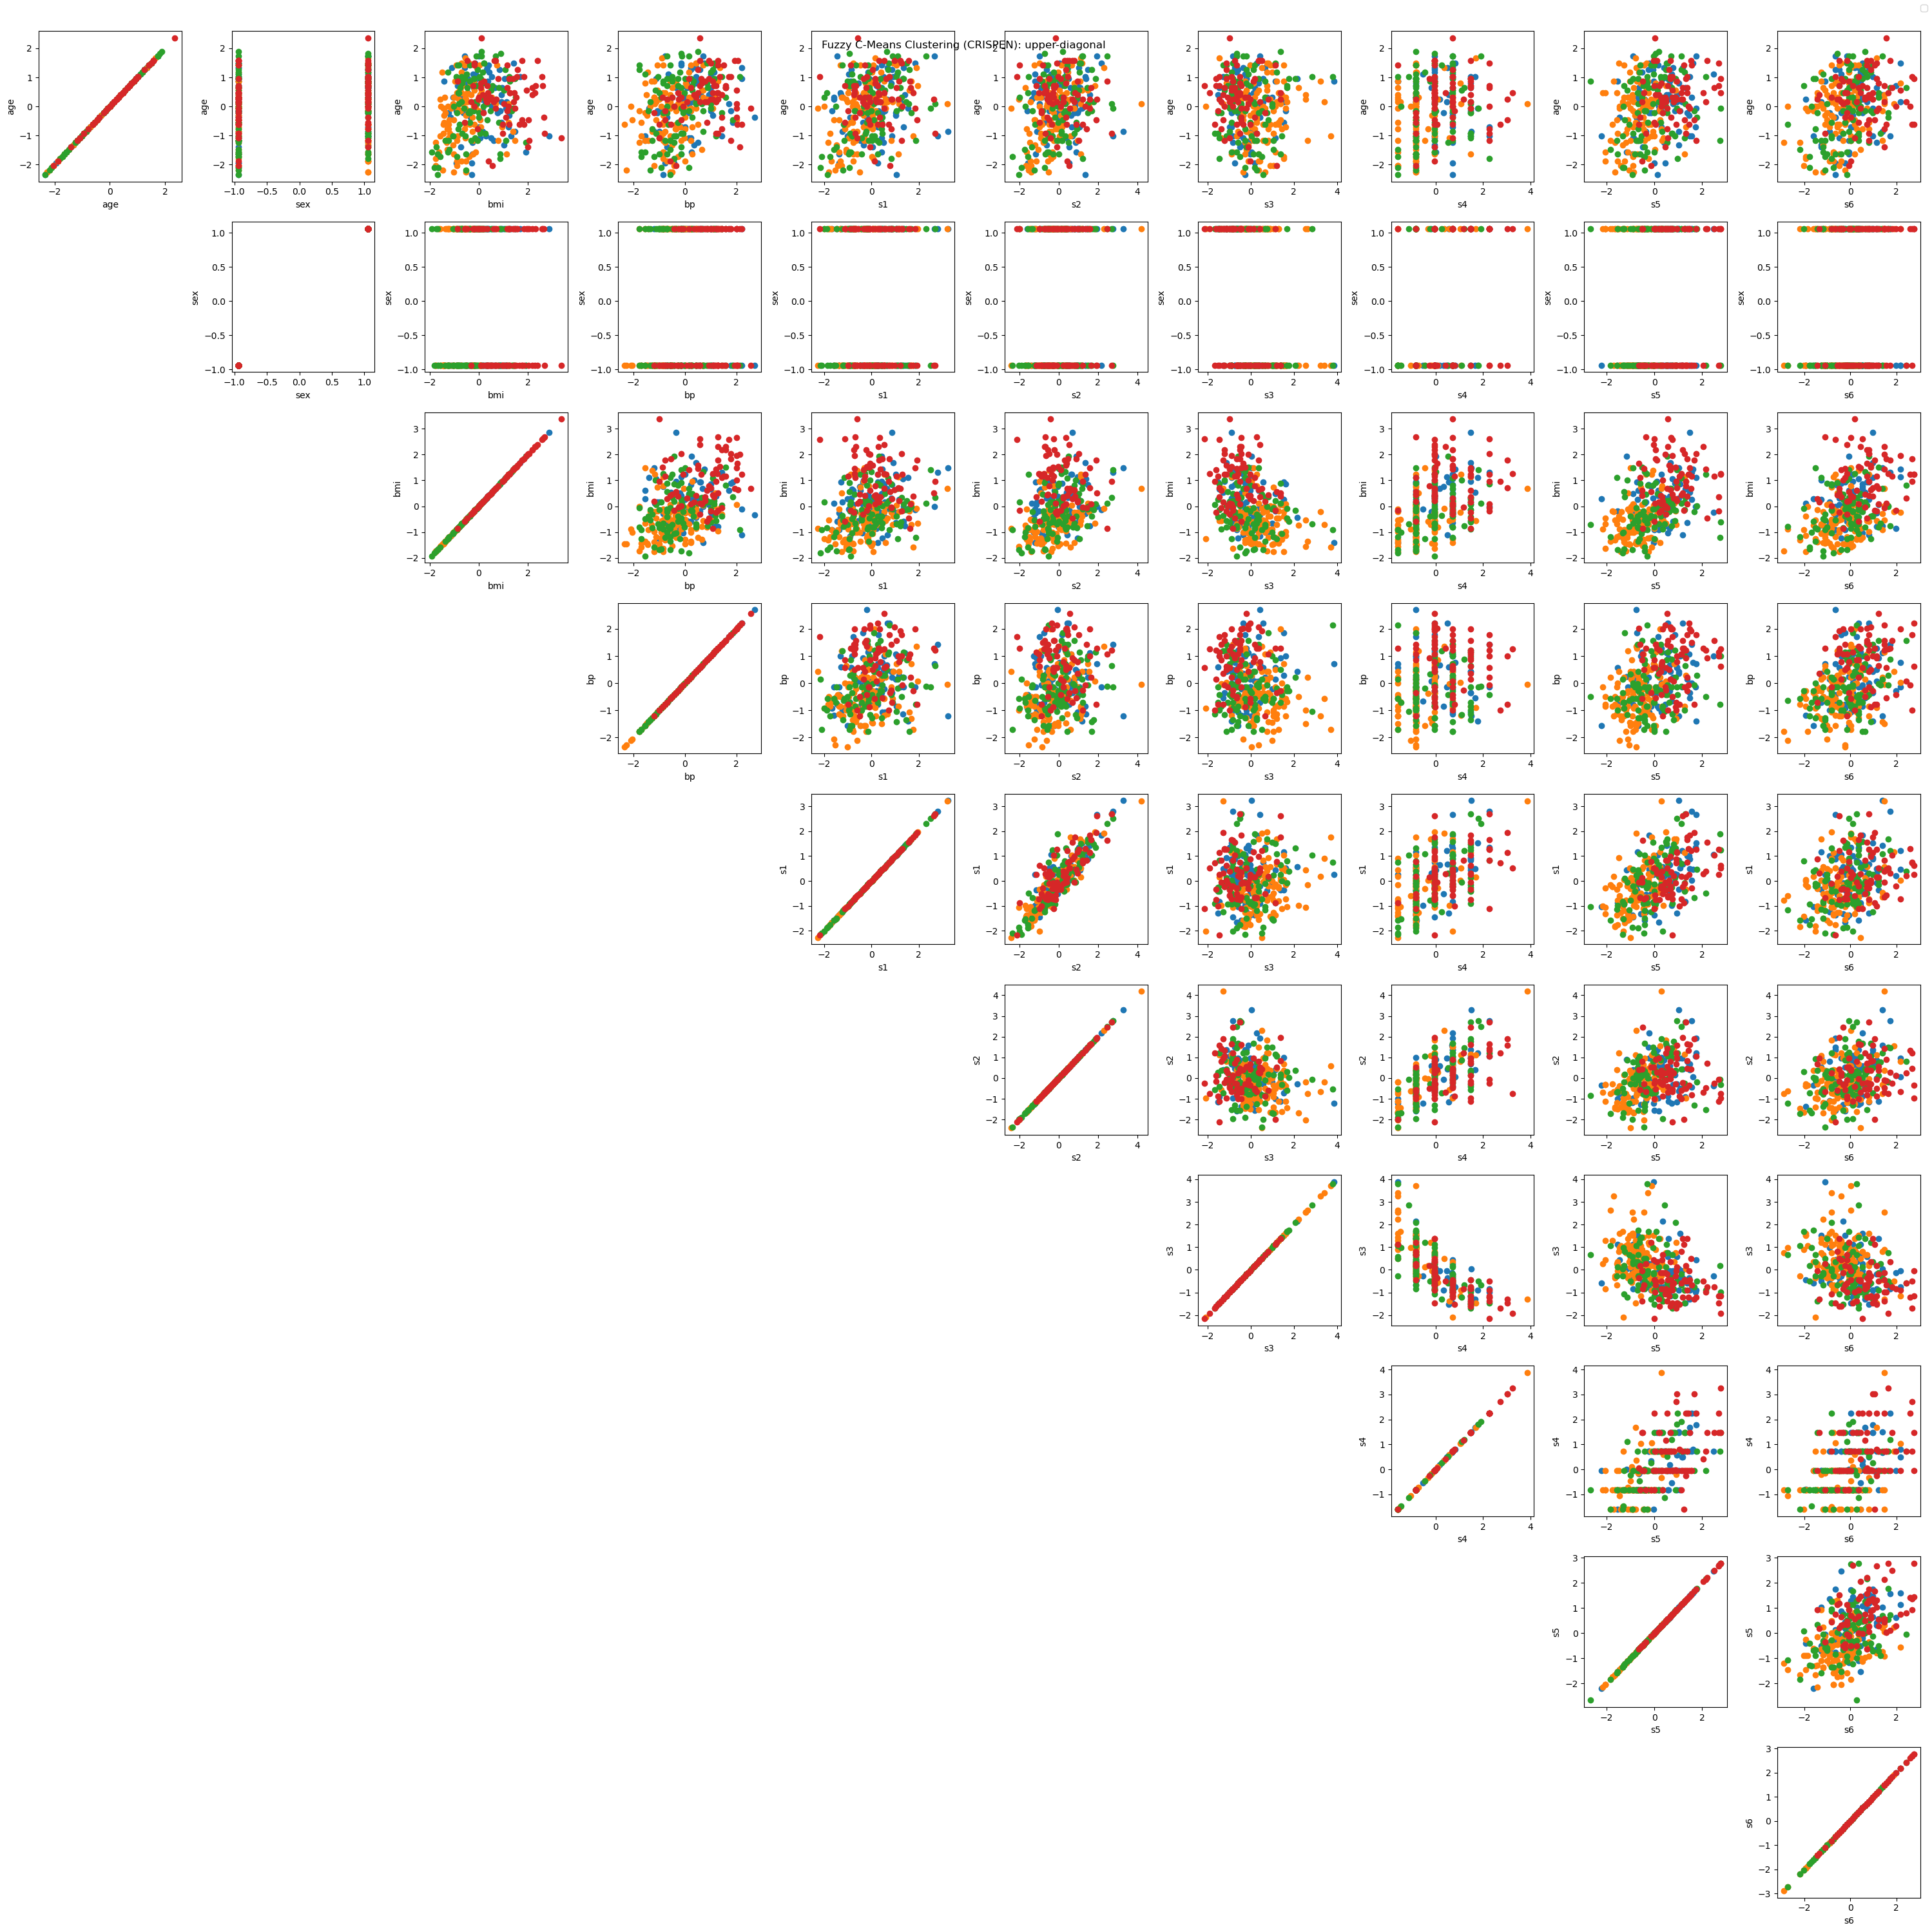

In [10]:
n_features = X.shape[1]
cluster_labels = np.argmax(u, axis=0)
# Configura figura com subplots
fig, axes = plt.subplots(n_features, n_features, figsize=(3*n_features, 3*n_features))

feature_labels = diabetes.data.columns

for i in range(n_features):
    for j in range(n_features):
        ax = axes[i, j]
        if i <= j:  # upper diagonal + diagonal
            for k in range(n_clusters):
                ax.scatter(
                    Xexp[cluster_labels == k, j],  # Feature 1
                    Xexp[cluster_labels == k, i],  # Feature 2
                    label=f'Cluster {k}' if (i==0 and j==i) else "",  # label só uma vez
                )
            # rotular eixos
            ax.set_xlabel(feature_labels[j])
            ax.set_ylabel(feature_labels[i])
        else:
            ax.axis('off')  # lower triangle desligado

# Legenda global
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:n_clusters], [f'Cluster {k}' for k in range(n_clusters)], loc='upper right')

plt.suptitle("Fuzzy C-Means Clustering (CRISPEN): upper-diagonal")
plt.tight_layout()
plt.show()

Antecedent Memership Function Visusalization

In [11]:
'''# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()'''

'# Gaussian formula\ndef gaussian(x, mu, sigma):\n    return np.exp(-0.5 * ((x - mu)/sigma)**2)\n\nlin=np.linspace(-2, 4, 500)\nplt.figure(figsize=(8,6))\n\ny_aux=[]\nfor j in range(n_clusters):\n# Compute curves\n    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))\n\n# Plot\n    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")\n\nplt.title("Projection of the membership functions on Feature 1")\nplt.xlabel("Feature 1")\nplt.ylabel("Degree of Membership")\nplt.legend()\nplt.grid(True)\nplt.show()'

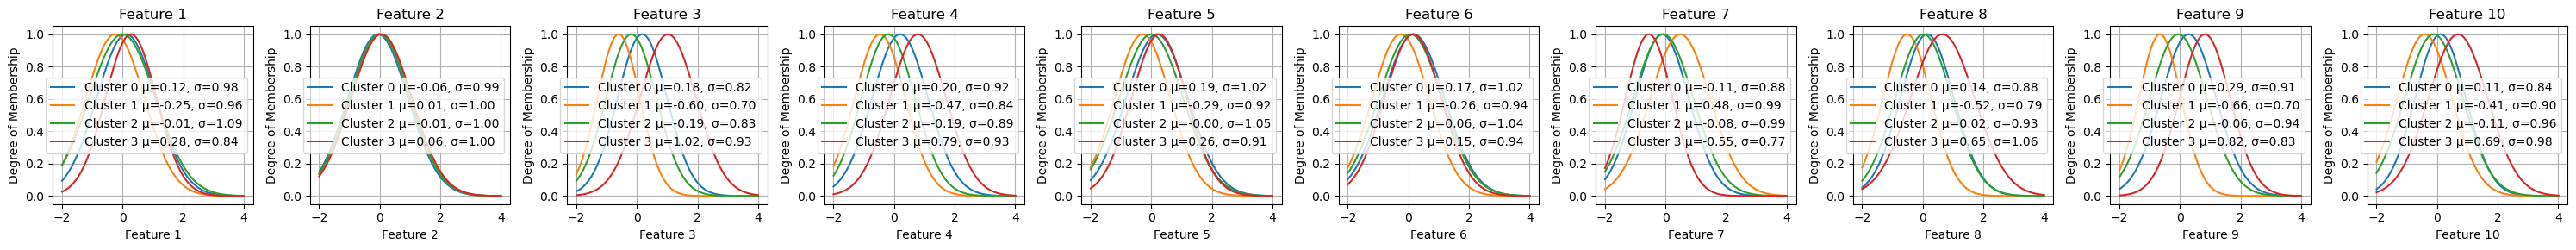

In [12]:
# Função Gaussiana
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

n_features = 10
lin = np.linspace(-2, 4, 500)

fig, axes = plt.subplots(1, n_features, figsize=(3*n_features, 3))

for i in range(n_features):  # loop pelas features
    ax = axes[i]
    for j in range(n_clusters):  # loop pelos clusters
        # Curva Gaussiana para cluster j e feature i
        y_curve = gaussian(lin, centers[j, i], sigmas[j, i])
        ax.plot(lin, y_curve, label=f"Cluster {j} μ={centers[j,i]:.2f}, σ={sigmas[j,i]:.2f}")
    
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel(f"Feature {i+1}")
    ax.set_ylabel("Degree of Membership")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Consequent Calculations

In [13]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [14]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [15]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [16]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_alternating(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        for p in model.consequents.parameters():  
            p.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        for p in model.consequents.parameters():  
            p.requires_grad = True
        for p in model.mfs.parameters():
            p.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        for p in model.mfs.parameters():
            p.requires_grad = True

In [17]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid_classic(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [18]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [19]:
# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1))


In [20]:
y_pred, _, _=model(Xte)
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'ACC:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:2476.79150390625


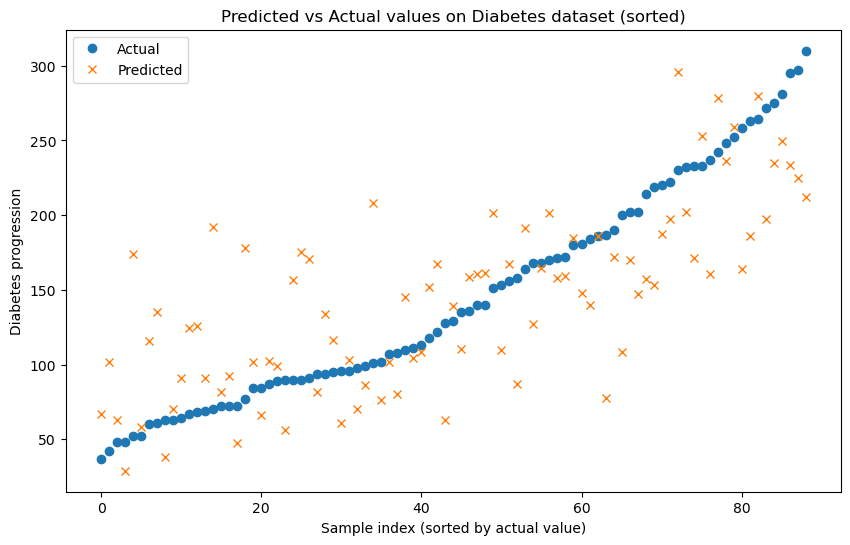

In [21]:
# Plot predictions vs actual
# Converter y_pred para numpy e flatten
y_pred_np = y_pred.detach().numpy().flatten()
yte_np = yte.detach().numpy()

# Obter índices que ordenam yte
sort_idx = np.argsort(yte_np)

# Ordenar yte e y_pred segundo esses índices
yte_sorted = yte_np[sort_idx]
y_pred_sorted = y_pred_np[sort_idx]

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(len(yte_sorted)), yte_sorted, label="Actual", marker="o", linestyle='')
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted", marker="x", linestyle='')

plt.xlabel("Sample index (sorted by actual value)")
plt.ylabel("Diabetes progression")
plt.title("Predicted vs Actual values on Diabetes dataset (sorted)")
plt.legend()
plt.show()